In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os



In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import cv2

from keras.layers import Flatten, Dense, Input,concatenate
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout
from keras.models import Model
from keras.models import Sequential

from sklearn.neighbors import NearestNeighbors

2023-06-16 14:23:34.616158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 14:23:34.674365: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 14:23:34.676914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-16 14:23:34.676922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [8]:
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=True, pooling='max', input_shape=(224, 224, 3))
basemodel = Model(inputs=vgg16.input, outputs=vgg16.get_layer('fc2').output)
basemodel.summary()

2023-06-16 14:24:26.837370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-16 14:24:26.837453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jal/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-16 14:24:26.837485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jal/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-16 14:24:26.837509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could n

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# File list creation

In [9]:
def get_feature_vector(image_path, file_list_index=''):
    img = mpimg.imread(image_path)
    if len(img.shape) > 2 and img.shape[2] == 4:
    #convert the image from RGBA2RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    if len(img.shape) ==3:
        img1 = cv2.resize(img, (224, 224))
        feature_vector = basemodel.predict(img1.reshape(1, 224, 224, 3))
        return feature_vector
    print(f'{file_list_index} {os.path.basename(image_path)} has only black and white channels. Not supported')
    return None

In [10]:
folder_path = '../raw_data/actors' # provide your path here

file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
for n, i in enumerate(file_list): print(n, os.path.splitext(os.path.basename(i))[0])

0 Tom Cruise b&w(18)
1 Keanu Reeves b&w (11)
2 Cate Blanchett B&w (2)
3 Kate Winslet b&w(8)
4 Johnny Depp b&w(5)
5 Keanu Reeves b&w(10)
6 Keanu Reeves b&w(12)
7 Tom Cruise b&w (16)
8 Johnny Depp b&w (4)
9 Nicole Kidman b&w(13)
10 Cate Blanchett b&w (1)
11 Kate winslet b&w (7)
12 Kate Winslet b&w (9)
13 Nicole Kidman b&w (14)
14 Tom Cruise b&w (17)
15 Cate Blanchett b&w


In [11]:
vectors = np.array([get_feature_vector(image, file_list_index=n) for n, image in enumerate(file_list)])

1/1 [==============================] - 0s 56ms/step


In [7]:
# def similarity_check(id1, id2, file_list, vectors):
#    print(os.path.splitext(os.path.basename(file_list[id1]))[0],'vs', os.path.splitext(os.path.basename(file_list[id2]))[0])
#    person1 = (os.path.splitext(os.path.basename(file_list[id1]))[0], vectors[id1])
#    person2 = (os.path.splitext(os.path.basename(file_list[id2]))[0], vectors[id2])
#    if type(vectors[id1]) and type(vectors[id2]) is not type(None): 
#        cos_sim = calculate_similarity(person1[1][0], person2[1][0])
#        euc_dist = np.linalg.norm(person1[1][0] - person2[1][0])
#        print('cosine based similarity', round(cos_sim,4) ) # the bigger the better
#        print('eucleadean distance',euc_dist) # the lower the better
#        return (person1[0], person2[0], cos_sim, euc_dist)
#    print('id for black and white photo detected. Not possible to check similarity')
#   return (person1[0], person2[0], 'Failed to compare', 'Failed to compare')

In [12]:
vectors_no_none = np.array([i[0] for i in vectors if type(i)!=type(None)])

df = pd.DataFrame([os.path.splitext(os.path.basename(i))[0] for i in file_list])\
        .rename(columns={0:'name'})
df = pd.concat([df,pd.DataFrame(vectors)], axis=1).rename(columns={0:'vector'})

vectors_df = df[~df['vector'].isna()].reset_index()
vectors_df.head()

ValueError: Must pass 2-d input. shape=(16, 1, 4096)

In [11]:
knn = NearestNeighbors(n_neighbors=len(vectors_no_none), n_jobs=-1)

knn.fit(vectors_no_none)

distances, indices = knn.kneighbors(vectors_no_none)

In [12]:
df_with_neighbors = pd.concat([vectors_df, pd.DataFrame(indices[:,1:])], axis=1)
df_with_neighbors[df_with_neighbors.columns[3:]] = df_with_neighbors[df_with_neighbors.columns[3:]].applymap(lambda i: df_with_neighbors.name.iloc[i])
df_with_neighbors.drop(columns=0, axis=0, inplace=True)
df_with_neighbors.head()

,index,name,vector,1,2,3,4,5,6,7,...,172,173,174,175,176,177,178,179,180,181
0,0,ellen_burstyn,"[[0.0, 0.0, 0.0, 1.9327561, 0.0, 0.0, 0.0, 0.0...",charlize_theron,maggie_smith,amy_adams,diane_kruger,frances_mcdormand,sharon_stone,rooney_mara,...,hugh_jackman,olga_kurylenko,gary_oldman,jennifer_aniston,samuel_l._jackson,kate_mara,leonardo_dicaprio,gloria_swanson,demi_moore,morgan_freeman
1,1,julia_roberts,"[[0.0, 0.0, 0.0, 0.2614107, 0.22301638, 6.9512...",robin_wright,kate_winslet,amy_adams,emma_watson,mélanie_laurent,alyson_hannigan,meryl_streep,...,johnny_depp,spencer_tracy,samuel_l._jackson,peter_sellers,edward_norton,russell_crowe,hugh_jackman,morgan_freeman,leonardo_dicaprio,javier_bardem
2,2,meryl_streep,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.3180058, 0.0, 0.0...",sharon_stone,kim_novak,tom_cruise,chloë_grace_moretz,amanda_plummer,jennifer_jason_leigh,rooney_mara,...,peter_o'toole,peter_sellers,johnny_depp,demi_moore,hugh_jackman,olga_kurylenko,samuel_l._jackson,javier_bardem,leonardo_dicaprio,morgan_freeman
3,4,jennifer_lawrence,"[[0.0, 0.0, 0.0, 0.68649805, 0.0, 1.4243515, 0...",brie_larson,chloë_grace_moretz,meryl_streep,robin_wright,kate_winslet,rooney_mara,michelle_pfeiffer,...,gloria_swanson,peter_sellers,russell_crowe,samuel_l._jackson,spencer_tracy,johnny_depp,hugh_jackman,leonardo_dicaprio,javier_bardem,morgan_freeman
4,5,kate_mara,"[[2.1564236, 0.0, 0.0, 0.0, 0.0, 5.182745, 1.3...",emma_stone,alec_guinness,bibi_andersson,katherine_parkinson,marion_cotillard,tom_cruise,lauren_cohan,...,cameron_diaz,gloria_swanson,morgan_freeman,scarlett_johansson,peter_o'toole,russell_crowe,demi_moore,leonardo_dicaprio,hugh_jackman,javier_bardem


In [1]:
import sys
sys.path.append("../")
import wikidata as wdt


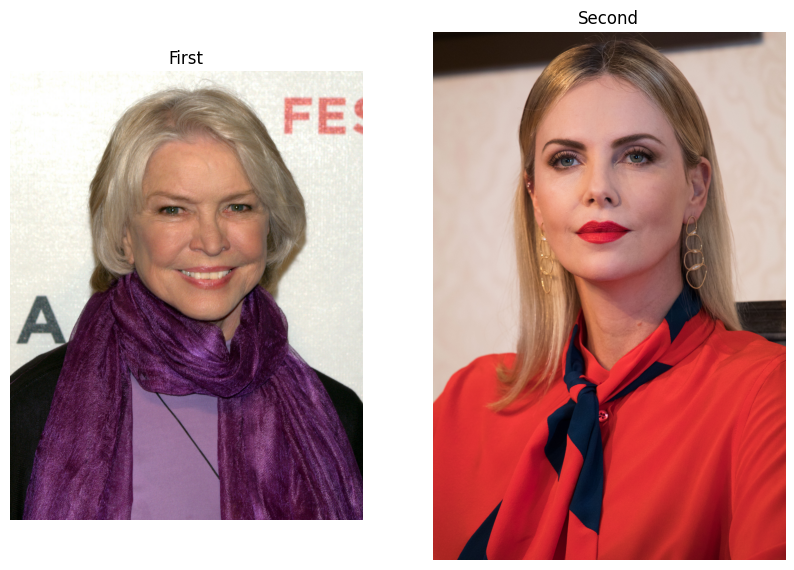

In [33]:

wdt.Tools.show_imgs("ellen_burstyn.jpg","charlize_theron.jpg",'../raw_data/output_wiki/')

In [17]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=3, random_state=0, perplexity=10)
projections = tsne.fit_transform(vectors_no_none, )

plotting_df = pd.concat([vectors_df, pd.DataFrame(projections)], axis=1)

fig = px.scatter_3d(
    plotting_df, x=0, y=1, z=2, hover_data='name'
)
fig.update_traces(marker_size=4)
fig.show()

In [21]:
# !pip install deepface
from deepface import DeepFace

# Deepface models
There are several models available:

• VGG-Face

• FaceNet (128D, 512D)

• OpenFace

• DeepID

• ArcFace

They are different in performance

In [95]:
# Available models
models = [
  "VGG-Face",
  "Facenet",
  "Facenet512",
  "OpenFace",
  "DeepFace",
  "DeepID",
  "ArcFace"
]

In [230]:
deepface_vectors_vgg = np.array([np.array(DeepFace.represent(i, model_name=models[0], enforce_detection=True)[0]['embedding']) for i in file_list])

# for i in file_list:
#     print(i)
#     print(DeepFace.represent(i, model_name=models[0], enforce_detection=True)[0]['embedding'])

In [161]:
!ls "../raw_data/actors/Nicole Kidman b&w (15).jpg"

'../raw_data/actors/Nicole Kidman b&w (15).jpg'


In [225]:
deepface_vectors_vgg

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         5.37552834,  2.30839467],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        10.26210022,  3.32723117],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         9.74395466,  4.2907815 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         5.07777596,  3.29059148],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         5.31747055,  2.528965  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         4.50704479,  2.1556437 ]])

In [231]:
knn_deepface = NearestNeighbors(n_neighbors=len(deepface_vectors_vgg), n_jobs=-1,algorithm='auto')

knn_deepface.fit(deepface_vectors_vgg)

deepface_distances, deepface_indices = knn_deepface.kneighbors(deepface_vectors_vgg)

In [227]:
from scipy.spatial import distance

# for i, m in enumerate(file_list):
#     print(i,m)
dist = distance.euclidean(deepface_vectors_vgg[0], deepface_vectors_vgg[5])
# dist2 = distance.euclidean(deepface_vectors_vgg[1], deepface_vectors_vgg[15])

In [220]:
print(dist)

91.52250926092563


In [232]:
deepface_df = pd.DataFrame([os.path.splitext(os.path.basename(i))[0] for i in file_list])\
        .rename(columns={0:'name'})
deepface_df = pd.concat([deepface_df, pd.DataFrame(deepface_indices)], axis=1)#.rename(columns={0:'vector'})

In [233]:
deepface_df[deepface_df.columns[1:]] = deepface_df[deepface_df.columns[1:]].applymap(lambda i: deepface_df.name.iloc[i])
# deepface_df.drop(columns="0", inplace=True)

deepface_df.drop(columns=0, axis=0)


,name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Tom Cruise b&w(18),Tom Cruise b&w (17),Keanu Reeves b&w(10),Tom Cruise b&w (16),Johnny Depp b&w (4),Keanu Reeves b&w(12),Kate Winslet b&w (9),Johnny Depp b&w(5),Nicole Kidman b&w (14),Nicole Kidman b&w(13),Cate Blanchett b&w,Cate Blanchett B&w (2),Kate winslet b&w (7),Keanu Reeves b&w (11),Kate Winslet b&w(8),Cate Blanchett b&w (1)
1,Keanu Reeves b&w (11),Keanu Reeves b&w(12),Keanu Reeves b&w(10),Tom Cruise b&w(18),Tom Cruise b&w (17),Tom Cruise b&w (16),Johnny Depp b&w (4),Johnny Depp b&w(5),Kate Winslet b&w (9),Kate winslet b&w (7),Nicole Kidman b&w (14),Cate Blanchett B&w (2),Kate Winslet b&w(8),Cate Blanchett b&w,Nicole Kidman b&w(13),Cate Blanchett b&w (1)
2,Cate Blanchett B&w (2),Nicole Kidman b&w (14),Cate Blanchett b&w (1),Kate Winslet b&w(8),Cate Blanchett b&w,Kate winslet b&w (7),Kate Winslet b&w (9),Johnny Depp b&w (4),Nicole Kidman b&w(13),Keanu Reeves b&w(10),Tom Cruise b&w(18),Johnny Depp b&w(5),Keanu Reeves b&w(12),Tom Cruise b&w (17),Tom Cruise b&w (16),Keanu Reeves b&w (11)
3,Kate Winslet b&w(8),Cate Blanchett B&w (2),Cate Blanchett b&w (1),Nicole Kidman b&w (14),Kate winslet b&w (7),Cate Blanchett b&w,Kate Winslet b&w (9),Johnny Depp b&w (4),Nicole Kidman b&w(13),Keanu Reeves b&w(10),Tom Cruise b&w(18),Johnny Depp b&w(5),Tom Cruise b&w (16),Tom Cruise b&w (17),Keanu Reeves b&w(12),Keanu Reeves b&w (11)
4,Johnny Depp b&w(5),Johnny Depp b&w (4),Keanu Reeves b&w(10),Keanu Reeves b&w(12),Tom Cruise b&w (16),Kate Winslet b&w (9),Tom Cruise b&w(18),Tom Cruise b&w (17),Nicole Kidman b&w (14),Cate Blanchett B&w (2),Cate Blanchett b&w,Kate winslet b&w (7),Cate Blanchett b&w (1),Kate Winslet b&w(8),Nicole Kidman b&w(13),Keanu Reeves b&w (11)
5,Keanu Reeves b&w(10),Keanu Reeves b&w(12),Johnny Depp b&w (4),Johnny Depp b&w(5),Tom Cruise b&w(18),Tom Cruise b&w (16),Tom Cruise b&w (17),Keanu Reeves b&w (11),Kate Winslet b&w (9),Nicole Kidman b&w (14),Cate Blanchett B&w (2),Cate Blanchett b&w,Kate winslet b&w (7),Kate Winslet b&w(8),Cate Blanchett b&w (1),Nicole Kidman b&w(13)
6,Keanu Reeves b&w(12),Keanu Reeves b&w(10),Johnny Depp b&w (4),Keanu Reeves b&w (11),Johnny Depp b&w(5),Tom Cruise b&w(18),Tom Cruise b&w (17),Tom Cruise b&w (16),Kate Winslet b&w (9),Cate Blanchett B&w (2),Nicole Kidman b&w (14),Kate winslet b&w (7),Kate Winslet b&w(8),Cate Blanchett b&w,Nicole Kidman b&w(13),Cate Blanchett b&w (1)
7,Tom Cruise b&w (16),Tom Cruise b&w (17),Keanu Reeves b&w(10),Tom Cruise b&w(18),Johnny Depp b&w (4),Johnny Depp b&w(5),Keanu Reeves b&w(12),Cate Blanchett b&w,Nicole Kidman b&w (14),Kate Winslet b&w (9),Kate winslet b&w (7),Cate Blanchett b&w (1),Cate Blanchett B&w (2),Kate Winslet b&w(8),Keanu Reeves b&w (11),Nicole Kidman b&w(13)
8,Johnny Depp b&w (4),Johnny Depp b&w(5),Keanu Reeves b&w(10),Keanu Reeves b&w(12),Kate Winslet b&w (9),Cate Blanchett B&w (2),Nicole Kidman b&w (14),Tom Cruise b&w(18),Tom Cruise b&w (16),Kate winslet b&w (7),Kate Winslet b&w(8),Cate Blanchett b&w,Tom Cruise b&w (17),Cate Blanchett b&w (1),Nicole Kidman b&w(13),Keanu Reeves b&w (11)
9,Nicole Kidman b&w(13),Cate Blanchett B&w (2),Cate Blanchett b&w,Nicole Kidman b&w (14),Johnny Depp b&w (4),Kate Winslet b&w (9),Kate winslet b&w (7),Kate Winslet b&w(8),Tom Cruise b&w(18),Cate Blanchett b&w (1),Tom Cruise b&w (17),Keanu Reeves b&w(10),Johnny Depp b&w(5),Tom Cruise b&w (16),Keanu Reeves b&w(12),Keanu Reeves b&w (11)


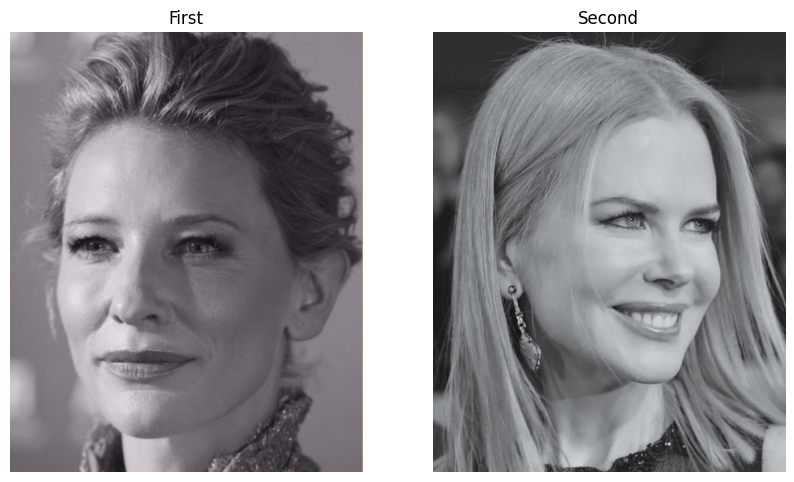

In [235]:

import sys
sys.path.append("../")
import wikidata as wdt

wdt.Tools.show_imgs("Cate Blanchett B&w (2).jpg","Nicole Kidman b&w (14).jpg","../raw_data/actors/")




In [ ]:
res = DeepFace.verify("../raw_data/Cate Blanchett B&w (2)", "../raw_data/actors/Johnny Depp b&w (4).jpg",distance_metric="euclidean_l2",model_name="DeepFace")

In [222]:
res

{'verified': False,
 'distance': 1.0333877829755465,
 'threshold': 0.64,
 'model': 'DeepFace',
 'detector_backend': 'opencv',
 'similarity_metric': 'euclidean_l2',
 'facial_areas': {'img1': {'x': 120, 'y': 304, 'w': 758, 'h': 758},
  'img2': {'x': 180, 'y': 170, 'w': 818, 'h': 818}},
 'time': 0.25}

In [176]:
deepface_distances[:,1:2]

array([[65.38153669],
       [52.63080907],
       [54.05883939],
       [75.84742403],
       [66.09121611],
       [65.94184032],
       [54.05883939],
       [59.0503545 ],
       [56.25737044],
       [58.43886181],
       [74.97793609],
       [66.09121611],
       [65.38153669],
       [57.4230006 ],
       [67.07342062],
       [52.63080907],
       [67.07342062]])

In [30]:
deepface_df.head(15)

,name,0,1,2,3,4,5,6,7,8,...,104,105,106,107,108,109,110,111,112,113
0,jack_lemmon,jack_lemmon,john_goodman,clint_eastwood,kevin_spacey,christopher_walken,bill_murray,alan_arkin,russell_crowe,robin_williams,...,richard_burton,clark_gable,katheryn_winnick,sean_connery,blake_lively,katherine_parkinson,kirsten_dunst,michelle_pfeiffer,rachel_weisz,robert_mitchum
1,michael_caine,michael_caine,jack_nicholson,robert_duvall,john_goodman,christopher_plummer,anthony_hopkins,charlton_heston,peter_o'toole,robert_redford,...,sean_connery,blake_lively,kaya_scodelario,michelle_pfeiffer,richard_burton,kirsten_dunst,katheryn_winnick,katherine_parkinson,rachel_weisz,robert_mitchum
2,spencer_tracy,spencer_tracy,clint_eastwood,gene_hackman,robert_duvall,anthony_hopkins,liam_neeson,martin_sheen,christopher_walken,alan_arkin,...,clark_gable,kaya_scodelario,richard_burton,katheryn_winnick,katherine_parkinson,kirsten_dunst,michelle_pfeiffer,blake_lively,robert_mitchum,rachel_weisz
3,mel_gibson,mel_gibson,russell_crowe,gene_hackman,peter_o'toole,robin_williams,javier_bardem,tommy_lee_jones,anthony_hopkins,christopher_walken,...,kirsten_dunst,burt_lancaster,kaya_scodelario,clark_gable,rachel_weisz,katherine_parkinson,katheryn_winnick,sean_connery,richard_burton,robert_mitchum
4,johnny_depp,johnny_depp,christopher_walken,benicio_del_toro,will_smith,leonardo_dicaprio,ben_kingsley,javier_bardem,harrison_ford,colin_firth,...,kaya_scodelario,katheryn_winnick,blake_lively,clark_gable,katherine_parkinson,rachel_weisz,sean_connery,kirsten_dunst,richard_burton,robert_mitchum
5,brad_pitt,brad_pitt,matthew_mcconaughey,javier_bardem,matt_damon,gary_oldman,hugh_jackman,russell_crowe,colin_firth,robert_downey_jr.,...,rachel_weisz,peter_sellers,henry_fonda,katheryn_winnick,edward_g._robinson,katherine_parkinson,robert_mitchum,clark_gable,sean_connery,richard_burton
6,george_c._scott,george_c._scott,alec_guinness,humphrey_bogart,jeff_bridges,kirk_douglas,jim_carrey,evangeline_lilly,tom_cruise,robert_mitchum,...,jason_robards,christian_bale,gary_cooper,steve_mcqueen,peter_sellers,buster_keaton,henry_fonda,sean_connery,clark_gable,richard_burton
7,gene_hackman,gene_hackman,anthony_hopkins,tommy_lee_jones,christopher_plummer,ian_mckellen,alan_arkin,spencer_tracy,ben_kingsley,robin_williams,...,kirsten_dunst,michelle_pfeiffer,blake_lively,katheryn_winnick,katherine_parkinson,rachel_weisz,robert_mitchum,sean_connery,clark_gable,richard_burton
8,benicio_del_toro,benicio_del_toro,leonardo_dicaprio,harrison_ford,alan_arkin,colin_firth,matt_damon,ralph_fiennes,will_smith,christopher_walken,...,kirsten_dunst,sean_connery,katheryn_winnick,blake_lively,michelle_pfeiffer,clark_gable,katherine_parkinson,rachel_weisz,richard_burton,robert_mitchum
9,gene_kelly,gene_kelly,william_holden,buster_keaton,gregory_peck,robert_de_niro,heath_ledger,leonardo_dicaprio,gary_cooper,tom_hanks,...,katherine_parkinson,cameron_diaz,katheryn_winnick,blake_lively,kaya_scodelario,jennifer_aniston,kirsten_dunst,michelle_pfeiffer,rachel_weisz,robert_mitchum


In [31]:
deepface_df[deepface_df['name']=='jim_carrey']

,name,0,1,2,3,4,5,6,7,8,...,104,105,106,107,108,109,110,111,112,113
23,jim_carrey,jim_carrey,kirk_douglas,laurence_olivier,chloe_grace_moretz,tom_cruise,evangeline_lilly,cary_grant,jeff_bridges,alec_guinness,...,gary_cooper,edward_norton,peter_sellers,steve_mcqueen,buster_keaton,christian_bale,henry_fonda,sean_connery,richard_burton,clark_gable


In [87]:
tsne = TSNE(n_components=3, random_state=0, perplexity=5)
projections = tsne.fit_transform(deepface_vectors_vgg, )

plotting_df = pd.concat([deepface_df['name'], pd.DataFrame(projections)], axis=1)

fig = px.scatter_3d(
    plotting_df, x=0, y=1, z=2, hover_data='name'
)
fig.update_traces(marker_size=4)
fig.show()